<a href="https://colab.research.google.com/github/GAIA-UNIL/Short-course-MPS/blob/main/MPS_SC_with_QS_Online.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install G2S and its Python interface

###Install and import G2S Python interface

In [ ]:
!pip install G2S libtiff --quiet
from g2s import g2s
g2s('--version')

## Download and compile G2S server with QuickSampling (QS) included

###Download G2S

In [ ]:
! git clone https://github.com/GAIA-UNIL/G2S.git --quiet

###Compile G2S

In [ ]:
%%capture
!export NVFLAGS='-gencode=arch=compute_35,code=sm_35 -gencode=arch=compute_37,code=sm_37 -gencode=arch=compute_50,code=sm_50 -gencode=arch=compute_52,code=sm_52 -gencode=arch=compute_60,code=sm_60 -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_70,code=compute_70'
!sudo apt -qq install build-essential libzmq3-dev libjsoncpp-dev zlib1g-dev libfftw3-dev libcurl4-openssl-dev -y
!sudo wget -q "https://raw.githubusercontent.com/zeromq/cppzmq/master/zmq.hpp" -O /usr/include/zmq.hpp
!( cd G2S/build && make c++ -j --silent)
#!bash G2S/build/c++-build/install_needs_W_VM.sh

###Start the G2S server

In [ ]:
!bash -c "cd G2S/build/c++-build/ && ./server -d"

##Test: Load libraries and a sample image

In [ ]:
import numpy
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import IPython.display

ti = numpy.array(Image.open(BytesIO(requests.get('https://raw.githubusercontent.com/GAIA-UNIL/TrainingImagesTIFF/master/stone.tiff').content)));

###Try echo to see if communication with G2S works

In [ ]:
a=g2s('-a','echo','-ti',ti,'-dt',[0])

In [ ]:
print(a)

In [ ]:
plt.imshow(a[0], interpolation='nearest')
plt.show()

### Load data

In [ ]:
simulation,tCPU=g2s('-a','qs','-ti',ti,'-di',numpy.zeros((200,200))*numpy.nan,'-dt',numpy.zeros((1,)),'-k',1.2,'-n',50,'-j',0.5);

In [ ]:
print(f'Computation time using CPU: {tCPU} s')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Unconditional simulation')
ax1.imshow(ti)
ax1.set_title('Training image');
ax1.axis('off');
ax2.imshow(simulation)
ax2.set_title('Simulation');
ax2.axis('off');
plt.show()

###Use GPU acceleartion

In [ ]:
!nvidia-smi

In [ ]:
simulation,tGPU,=g2s('-a','qs','-ti',ti,'-di',numpy.zeros((200,200))*numpy.nan,'-dt',numpy.zeros((1,)),'-k',1.2,'-n',50,'-ki',numpy.ones((51,51)),'-W_CUDA',0);
print(f'Computation time using GPU: {tGPU} s')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Unconditional simulation using GPU')
ax1.imshow(ti)
ax1.set_title('Training image');
ax1.axis('off');
ax2.imshow(simulation)
ax2.set_title('Simulation');
ax2.axis('off');
plt.show()

# Basic concept

In [ ]:
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import math
import imageio

Load a training image (TI)

In [ ]:
source = numpy.array(Image.open(BytesIO(requests.get('https://raw.githubusercontent.com/GAIA-UNIL/TrainingImagesTIFF/master/stone.tiff').content)));
plt.figure(figsize=(10,10))
plt.imshow(source, cmap='gray');
plt.axis('off');
plt.show();

_n_ defines the number of neigbors to take into account during simulation 

In [ ]:
data,indexMap1,_=g2s('-a','qs','-ti',source,'-dt',np.array([0]),'-di',np.ones([200,200])*np.nan,'-k',1,'-n',20);
plt.figure(figsize=(10,10))
plt.imshow(data, cmap='gray');
plt.axis('off');
plt.show();

In [ ]:
data,indexMap2,_=g2s('-a','qs','-ti',source,'-dt',np.array([0]),'-di',np.ones([200,200])*np.nan,'-k',2,'-n',300);
plt.figure(figsize=(10,10))
plt.imshow(data, cmap='gray');
plt.axis('off');
plt.show();

We can track the position of each simulated pixel in the orginal training image

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10));
fig.suptitle('index map')
ax1.imshow(indexMap1)
ax1.set_title('n=20');
ax1.axis('off');
ax2.imshow(indexMap2)
ax2.set_title('n=300 (verbatim copy)');
ax2.axis('off');
plt.show()

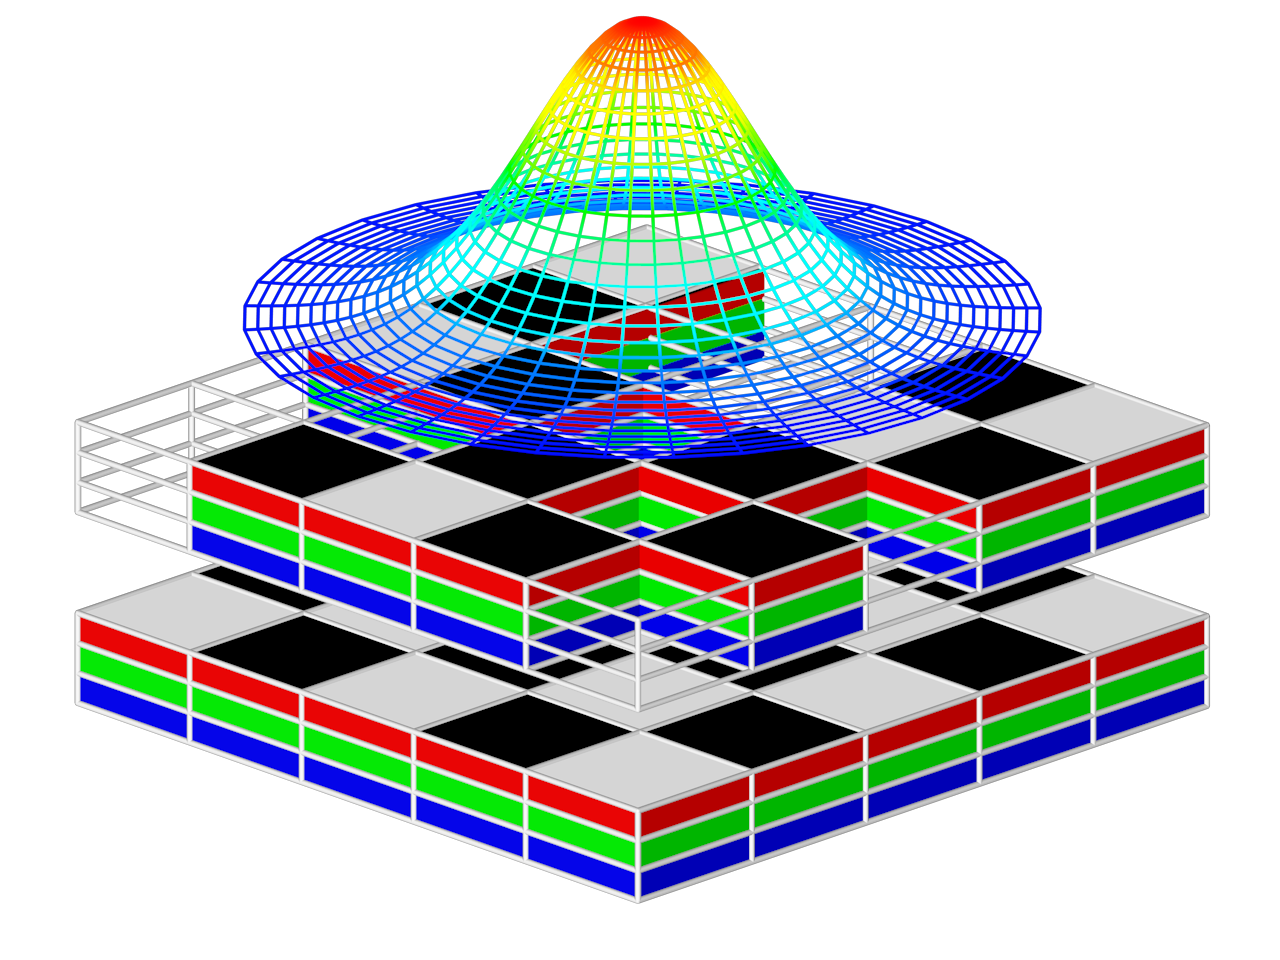
Why should the neighbors have the same importance in computing the pattern mismatch? Close neighbors can have more importance than far ones. Two main possible scenarios here:

1. We threshold after a given distance, ignoring the neighbors beyond it (weight of 0)
2. We impose a radial decay on the weight: the farther the less important the neighbor will be (here an exponential decay is used)

In [ ]:
data,=g2s('-a','qs','-ti',source,'-dt',np.array([0]),'-di',np.ones([200,200])*np.nan,'-k',2,'-n',100,'-ki',np.ones([51,51]));
plt.figure(figsize=(10,10))
plt.imshow(data, cmap='gray');
plt.axis('off');
plt.show();

In [ ]:
kernel=np.exp(-(1e-1)*ndimage.morphology.distance_transform_edt(np.pad([[0]],(25,25),constant_values=1)));
print(kernel)
plt.figure(figsize=(10,10))
data,=g2s('-a','qs','-ti',source,'-dt',np.array([0]),'-di',np.ones([200,200])*np.nan,'-k',2,'-n',100,'-ki',kernel);
plt.imshow(data, cmap='gray');
plt.axis('off');
plt.show();

#1D Example: Time series analysis and modelling

In [ ]:
#%% SIMULATION OF DAILY RAINFALL TIME-SERIES USING THE MULTIPLE-POINT ALGORITHM G2S
# IMPORT PACKAGES
from g2s import g2s
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'family' : 'DejaVu Sans',
        'size'   : 14}
rc('font', **font)
from datetime import date
import matplotlib.patches as ptc


In [ ]:
#%% DEFINE TIME-SERIES ANALYSIS FUNCTIONS

def triang(x,phase,length,amplitude): # triangular function for calendar periodicity
    alpha=(amplitude)/(length/2)
    return -amplitude/2+amplitude*((x-phase)%length==length/2) \
            +alpha*((x-phase)%(length/2))*((x-phase)%length<=length/2) \
            +(amplitude-alpha*((x-phase)%(length/2)))*((x-phase)%length>length/2)

def ts_compare(td,r,rsim): # visual comparison of two time series
    plt.figure(figsize=(10,20))
    ax1=plt.subplot(2,1,1)
    plt.plot(td,r)
    plt.title('Darwin daily rainfall')
    plt.xlabel('time')
    plt.ylabel('rainfall amount [mm]')
    plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
    plt.plot(td,rsim)
    plt.title('Simulation')
    plt.xlabel('time')
    plt.ylabel('rainfall amount [mm]')

def hist_comp(r,rsim): # histogram comparison
    nr=np.shape(rsim)[1]
    plt.figure()
    nbins=20 # number of bins
    bin_edges=np.linspace(0,np.max(r),num=nbins+1) # bin edges
    bin_centers=0.5*(bin_edges[1:] + bin_edges[:-1]) # bin centers
    y,x=np.histogram(r,bin_edges) # data histogram (line)
    ax1=plt.plot(bin_centers,y,'-o',label='data')
    ysim=np.empty([nr,nbins]) # simulation histogram (boxplot)
    for i in range(nr):
        ysim[i,:],x=np.histogram(rsim[:,i],bin_edges)
    plt.violinplot(ysim,positions=bin_centers,widths=20)
    ax2 = ptc.Patch(color='orange') # fake handle for legend
    # cosmetics
    plt.yscale('log')
    plt.title('Daily rainfall frequency distribution')
    plt.xlabel('rainfall amount [mm]')
    plt.ylabel('absolute frequency')
    plt.legend([ax1[0],ax2],['reference','simulations'])
    plt.ylim([0.90,plt.gca().get_ylim()[1]])

def monthly_mean(r,rsim,td): # montly mean boxplot
    nr=np.shape(rsim)[1]
    tm=np.array([td[i].strftime('%m') for i in range(np.shape(td)[0])]) # extract month number
    mnum=np.unique(tm) # list of month numbers
    rm=[np.nanmean(r[tm==i]) for i in mnum] # mean mointhly rainfall for data
    rsimm=np.empty([nr,len(mnum)])
    for j in range(nr):
        rsimm[j,:]=[np.nanmean(rsim[tm==i,j]) for i in mnum] # the same for simulations
    mnames=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov','Dec']
    plt.figure()
    ax1=plt.plot(mnames,rm,'-o')
    plt.title('Darwin monthly mean daily rianfall [mm]')
    plt.violinplot(rsimm,positions=np.arange(len(mnum)))
    ax2 = ptc.Patch(color='orange') # fake handle for legend
    plt.legend([ax1[0],ax2],['data','simulations'])

def ds_length(r): # compute dry-spell lengths
    rdw=r>0
    dl=[]
    n=0
    for i in range(len(rdw)):
        if rdw[i]==0:
            n=n+1
        else:
            dl.append(n)
            n=0
    dl=np.array(dl)
    return dl[dl!=0]

def ds_hist(r,rsim): # dry-spell histogram
    nr=np.shape(rsim)[1]
    rl=ds_length(r)
    rsiml=np.array([ds_length(rsim[:,i]) for i in range(nr)])
    plt.figure()
    nbins=20 # number of bins
    bin_edges=np.linspace(0,np.max(rl),num=nbins+1) # bin edges
    bin_centers=0.5*(bin_edges[1:] + bin_edges[:-1]) # bin centers
    y,x=np.histogram(rl,bin_edges) # data histogram (line)
    ax1=plt.plot(bin_centers,y,'-o',label='data')
    ysim=np.empty([nr,nbins]) # simulation histogram (boxplot)
    for i in range(nr):
        ysim[i,:],x=np.histogram(rsiml[i],bin_edges)
    plt.violinplot(ysim,positions=bin_centers,widths=10)
    ax2 = ptc.Patch(color='orange') # fake handle for legend
    # cosmetics
    plt.yscale('log')
    plt.title('Dry-spell frequency distribution')
    plt.xlabel('spell length [days]')
    plt.ylabel('absolute frequency')
    plt.legend([ax1[0],ax2],['data','simulations'])

In [ ]:
#%% IMPORT DATA (Darwin historical daily rainfall time-series, available from http://www.bom.gov.au/)
datapath="https://bitbucket.org/orianif/g2s_time_series_tutorial/raw/6b8b4bc9d725307c6a8d997b189e28019ad91ae9/data/darwin.csv"
r=np.genfromtxt(datapath, delimiter=",", skip_header=1, usecols=(5)) # rainfall amount
t=np.genfromtxt(datapath,delimiter = ",",skip_header=1,usecols=(2,3,4),dtype="int") # timestamp
td=[date(t[i,0],t[i,1],t[i,2]) for i in range(np.shape(t)[0])] # stimestamp to date object
plt.figure(figsize=(20,10))
plt.title('Darwin daily rainfall')
plt.xlabel('time')
plt.ylabel('rainfall amount [mm]')
plt.plot(td,r)

In [ ]:
#%% simulation using QS: rainfall amount only
#serverAddress='localhost'  # server address not needed in colab
ti = r # training image
di = np.empty_like(ti)*np.nan # empty simulation grid (destination image)
dt = np.array([0]) # data type (numpy array, 1 element per variable): 0 = continuous, 1 = categorical
k = 1 # quantile threshold (take a random pattern among the best k found)
n = 20 # maximum number of neighbors (the n informed and closest)
ki = np.ones([101,1]) # uniform kernel
s = 100 # initial seed
jb = 1 # number of parallel jobs (available from colab)
nr = 10 # number of realizations
# launch simulation
rsim=np.empty([len(r),nr])
print('performing ' + str(nr) + ' time-series simulations:')
for i in range(nr):
    s=s+1
    print("realization " + str(i))
    simout=g2s('-a','qs','-ti',ti,'-di',di,'-dt',dt,'-ki',ki,'-k', k,'-n', n,'-s', s, '-j',jb); # to run on your machine add the argmunet '-sa',serverAddress
    rsim[:,i]=simout[0]
print("simulations completed!")

In [ ]:
#%% RESULT ANALYSIS
# visual comparison
plt.figure(figsize=(10,20))
ax1=plt.subplot(2,1,1)
plt.plot(td,r)
plt.title('Darwin daily rainfall')
plt.xlabel('time')
plt.ylabel('rainfall amount [mm]')
plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
plt.plot(td,rsim[:,0])
plt.title('One simulation')
plt.xlabel('time')
plt.ylabel('rainfall amount [mm]')

#%% histogram
hist_comp(r,rsim)

#%% monthly mean rainfall
monthly_mean(r,rsim,td)

#%% dry-spell histogram
ds_hist(r,rsim)

In [ ]:
#%% DEFINE AN AUXILIARY VARIABLE: calendar position
tr1=triang(np.arange(len(td)),0,365,1)
tr2=triang(np.arange(len(td)),365/4,365,1)
plt.figure()
plt.plot(r)
plt.plot(tr1*50)
plt.plot(tr2*50)


In [ ]:
#%% simulation using QS: multivariate rainfall + calendar <----
#serverAddress='localhost'  # server address not needed in colab
ti = np.stack([tr1,tr2,r],axis=1) # training image including the calendar position variables <----
di = np.empty_like(ti)*np.nan # empty simulation grid (destimantion image)
di[:,0:2]=ti[:,0:2] # add the calendar position as conditioning variables <----
dt = np.array([0,0,0]) # data type (numpy array, 1 element per variable): 0 = continuous, 1 = categorical <----
s = 100 # initial seed
jb = 1 # number of parallel jobs
nr = 10 # number of realizations
k = 1 # quantile threshold (take a random pattern among the best k found)
ki = np.ones([101,3]) # uniform multivariate kernel <----
n = 10 # maximum number of neighbors (the n informed and closest)
# launch simulation
rsim=np.empty([len(r),nr]) # preallocate output array
print('performing ' + str(nr) + ' time-series simulations:')
for i in range(nr):
    s=s+1
    print("realization " + str(i))
    simout=g2s('-a','qs','-ti',ti,'-di',di,'-dt',dt,'-ki',ki,'-k', k,'-n', n,'-s', s, '-j',jb); # to run on your machine add the argmunet '-sa',serverAddress
    rsim[:,i]=simout[0][:,2] # <---- retrieve rainfall amount only
print("simulations completed!")

In [ ]:
#%% RESULT ANALYSIS
# visual comparison
plt.figure(figsize=(10,20))
ax1=plt.subplot(2,1,1)
plt.plot(td,r)
plt.title('Darwin daily rainfall')
plt.xlabel('time')
plt.ylabel('rainfall amount [mm]')
plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
plt.plot(td,rsim[:,0])
plt.title('Simulation')
plt.xlabel('time')
plt.ylabel('rainfall amount [mm]')

#%% histogram
hist_comp(r,rsim)

#%% monthly mean rainfall
monthly_mean(r,rsim,td)

#%% dry-spell histogram
ds_hist(r,rsim)

In [ ]:
#%% DEFINE A SECOND AUXILIARY VARIABLE: daily dry/wet indicator (1 = wet, 0 = dry)
rdw=r>0
plt.figure()
plt.plot(r)
plt.plot(rdw*10)


In [ ]:
#%% simulation using QS: multivariate rainfall + calendar + dry spell <----
#serverAddress='localhost'  # server address not needed in colab
ti = np.stack([tr1,tr2,rdw,r],axis=1) # training image <----
di = np.empty_like(ti)*np.nan # empty simulation grid (destimantion image)
di[:,0:2]=ti[:,0:2] # add annual seasonality as conditioning vairables <----
dt = np.array([0,0,0,0]) # data type (numpy array, 1 element per variable): 0 = continuous, 1 = categorical <----
s = 100 # initial seed
jb = 1 # number of parallel jobs
nr = 10 # number of realizations
k = 1 # quantile threshold (take a random value among the best k-neighbors)
ki = np.ones([101,4]) # uniform multivariate kernel  <----
n = 20 # maximum number of neighbors (the n informed and closest)
# launch simulation
rsim=np.empty([len(r),nr]) # preallocate output array <----
print('performing ' + str(nr) + ' time-series simulations:')
for i in range(nr):
    s=s+1
    print("realization " + str(i))
    simout=g2s('-a','qs','-ti',ti,'-di',di,'-dt',dt,'-ki',ki,'-k', k,'-n', n,'-s', s, '-j',jb); # to run on your machine add the argmunet '-sa',serverAddress
    rsim[:,i]=simout[0][:,3] # <---- retrieve rainfall amount only
print("simulations completed!")


In [ ]:
#%% RESULT ANALYSIS
#%% visual comparison
plt.figure(figsize=(10,20))
ax1=plt.subplot(2,1,1)
plt.plot(td,r)
plt.title('Darwin daily rainfall')
plt.xlabel('time')
plt.ylabel('rainfall amount [mm]')
plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
plt.plot(td,rsim[:,0])
plt.title('Simulation')
plt.xlabel('time')
plt.ylabel('rainfall amount [mm]')

#%% histogram
hist_comp(r,rsim)

#%% monthly mean rainfall
monthly_mean(r,rsim,td)

#%% dry-spell histogram
ds_hist(r,rsim)

#Advanced

##Gap-filling

a simple fucntion to display results

In [ ]:
def displayIm(im):
  plt.figure(figsize=(20,20));
  plt.imshow(im);
  plt.axis('off');
  plt.show();

###Univariate gap‐filling

We load the "Bengladesh" image, the image as a gap in the center, that we need to fill.

In [ ]:
ti = numpy.array(Image.open(BytesIO(requests.get('https://raw.githubusercontent.com/GAIA-UNIL/TrainingImagesTIFF/master/Bengladesh_hole.tiff').content)));
displayIm(ti)

For gap-filling using the image to simulate itself, we juste use the same image for both parameter: di and ti.


---


PS. here we use '-W_CUDA',0 that use the GPU 0 as accelerator. You can remove 
it to see the performance difference. If the difference look to be extreme in this Colab, on you own machines, the difference would be smaller.

In [ ]:
data,t,=g2s('-a','qs','-ti',ti,'-dt',[0],'-di',ti,'-k',1.2,'-n',50,'-ki',numpy.ones([51,51]),'-W_CUDA',0);
displayIm(data)
print('computation in ',t,'s');

We compute many realisation to check the E-type (mean) and the variation (give use a confidency map)

In [ ]:
data=numpy.empty(ti.shape+(10,));
for i in range(data.shape[-1]):
  data[:,:,i],=g2s('-a','qs','-ti',ti,'-dt',[0],'-di',ti,'-k',1.2,'-n',50,'-ki',numpy.ones([51,51]),'-W_CUDA',0);
displayIm(numpy.mean(data,axis=2))
displayIm(numpy.std(data,axis=2))

###Multivariate gap‐filling

We load a Landsat 7 image that has line gap, that are typical of this sensor.
The image as B,G,R, NIR, and SW (short-wave) bands. (here we display only RGB)

In [ ]:
import numpy
from PIL import Image
import requests
from io import BytesIO
from libtiff import TIFF

!wget -qq 'https://raw.githubusercontent.com/GAIA-UNIL/TrainingImagesTIFF/master/L7_CHplateau.tiff';
ti = TIFF.open('L7_CHplateau.tiff').read_image();
displayIm(ti[:,:,2::-1])

We reapply the same strategy as the previous cas but with set to hangle teh 5 variable available.

In [ ]:
data,=g2s('-a','qs','-ti',ti,'-dt',[0]*ti.shape[-1],'-di',ti,'-k',1.2,'-n',50,'-ki',numpy.ones([51,51]),'-W_CUDA',0);
displayIm(data[:,:,2::-1])

## Simulation with fully informed covariable (colorization)

Here we explore a scenario where we have missing bands on a satellite image. This can be a very hard task since here there is a poor correlation between the known and simulated bands.

In [ ]:
import scipy.ndimage
ti1=ti[:ti.shape[0]//2,:,:];
di=ti[ti.shape[0]//2:,:,:];
di[:,:,:3]=numpy.nan;

displayIm(data[:,:,2:])

plt.scatter(ti1[:,:,1].flat, ti1[:,:,3].flat)
plt.xlabel("Green")
plt.ylabel("NIR")
plt.show()
plt.scatter(ti1[:,:,1].flat, ti1[:,:,4].flat)
plt.xlabel("Green")
plt.ylabel("SW")
plt.show()



In [ ]:

kernel=numpy.exp(-1*scipy.ndimage.morphology.distance_transform_edt(numpy.pad([[[0]]]*5,(25,25),constant_values=1)));

data,=g2s('-a','qs','-ti',ti1,'-dt',[0]*ti.shape[-1],'-di',di,'-k',1,'-n',16,'-ki',kernel,'-W_CUDA',0);
displayIm(data[:,:,2::-1])

#Shutdown the server

In [ ]:
a=g2s('-shutdown','-p')